In [5]:
import botocore.session as s
from botocore.exceptions import ClientError
import boto3.session
import json
import boto3
import sagemaker
import s3fs
import time
import os
import random
import datetime
import operator
from botocore.exceptions import WaiterError
from botocore.waiter import WaiterModel
from botocore.waiter import create_waiter_with_client

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [6]:
# Create custom waiter for the Redshift Data API to wait for finish execution of current SQL statement
waiter_name = 'DataAPIExecution'

delay=2
max_attempts=3

#Configure the waiter settings
waiter_config = {
  'version': 2,
  'waiters': {
    'DataAPIExecution': {
      'operation': 'DescribeStatement',
      'delay': delay,
      'maxAttempts': max_attempts,
      'acceptors': [
        {
          "matcher": "path",
          "expected": "FINISHED",
          "argument": "Status",
          "state": "success"
        },
        {
          "matcher": "pathAny",
          "expected": ["PICKED","STARTED","SUBMITTED"],
          "argument": "Status",
          "state": "retry"
        },
        {
          "matcher": "pathAny",
          "expected": ["FAILED","ABORTED"],
          "argument": "Status",
          "state": "failure"
        }
      ],
    },
  },
}

In [7]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [8]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

## Retrieve DB details from AWS Secrets Manager
We need to retrieve from AWS Secrets Manager-
* Cluster Identifier
* Secrets ARN
* Database name

In [9]:
secret_name='redshift-dataapidemo' ## replace the secret name with yours
session = boto3.session.Session()
region = session.region_name

client = session.client(
        service_name='secretsmanager',
        region_name=region
    )

try:
    get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    secret_arn=get_secret_value_response['ARN']

except ClientError as e:
    print("Error retrieving secret. Error: " + e.response['Error']['Message'])
    
else:
    # Depending on whether the secret is a string or binary, one of these fields will be populated.
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
    else:
        secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            
secret_json = json.loads(secret)

cluster_id=secret_json['dbClusterIdentifier']
db=secret_json['db']
print("Cluster_id: " + cluster_id + "\nDB: " + db + "\nSecret ARN: " + secret_arn)

Cluster_id: rsdataapi-notebook-redshiftcluster-1gloapv8wxjh6
DB: nyctaxi
Secret ARN: arn:aws:secretsmanager:us-east-2:413094830157:secret:redshift-dataapidemo-X5p0oU


We will create the Data API client. For the rest of the notebook we will use this Data API client `client_redshift`.

In [10]:
bc_session = s.get_session()

session = boto3.Session(
        botocore_session=bc_session,
        region_name=region,
    )

# Setup the client
client_redshift = session.client("redshift-data")
print("Data API client successfully loaded")

Data API client successfully loaded


## List Schema
We first list the schema in current database.

In [11]:
client_redshift.list_schemas(
    Database= db, 
    SecretArn= secret_arn, 
    ClusterIdentifier= cluster_id)["Schemas"]

['catalog_history',
 'information_schema',
 'pg_catalog',
 'pg_internal',
 'public',
 'taxischema']

In [12]:
client_redshift.list_tables(
    Database= db, 
    SecretArn= secret_arn, 
    SchemaPattern='pg_catalog',
    TablePattern='pg_attr%',
    ClusterIdentifier= cluster_id)["Tables"]

[{'name': 'pg_attrdef_adrelid_adnum_index',
  'schema': 'pg_catalog',
  'type': 'SYSTEM INDEX'},
 {'name': 'pg_attrdef_oid_index',
  'schema': 'pg_catalog',
  'type': 'SYSTEM INDEX'},
 {'name': 'pg_attribute_acl_attrelid_attnum_index',
  'schema': 'pg_catalog',
  'type': 'SYSTEM INDEX'},
 {'name': 'pg_attribute_relid_attnam_index',
  'schema': 'pg_catalog',
  'type': 'SYSTEM INDEX'},
 {'name': 'pg_attribute_relid_attnum_index',
  'schema': 'pg_catalog',
  'type': 'SYSTEM INDEX'},
 {'name': 'pg_attrdef', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_attribute', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_attribute_acl', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_attribute_info', 'schema': 'pg_catalog', 'type': 'SYSTEM VIEW'}]

## Initiating Waiter
Initiating the custom waiter for subseqent `execute_statement` Data API call to return FINISHED signal.

In [13]:
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

Create the schema `taxischema` and the table `nyc_greentaxi`.

In [ ]:
query_str = "create schema taxischema;"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
id=res["Id"]

# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)   
    print("Done waiting to finish Data API.") 
except WaiterError as e:
    print (e)
    
desc=client_redshift.describe_statement(Id=id)
print("Status: " + desc["Status"] + ". Excution time: %d miliseconds" %float(desc["Duration"]/pow(10,6)))

query_str = 'create table taxischema.nyc_greentaxi(\
vendorid varchar(10),\
lpep_pickup_datetime timestamp,\
lpep_dropoff_datetime timestamp,\
store_and_fwd_flag char(1),\
ratecodeid int,\
pulocationid int,\
dolocationid int,\
passenger_count int,\
trip_distance decimal(8,2),\
fare_amount decimal(8,2),\
extra decimal(8,2),\
mta_tax decimal(8,2),\
tip_amount decimal(8,2),\
tolls_amount decimal(8,2),\
ehail_fee varchar(100),\
improvement_surcharge decimal(8,2),\
total_amount decimal(8,2),\
payment_type varchar(10),\
trip_type varchar(10),\
congestion_surcharge decimal(8,2)\
)\
sortkey (vendorid);'

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
id=res["Id"]

try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)
    
desc=client_redshift.describe_statement(Id=id)
print("Status: " + desc["Status"] + ". Excution time: %d miliseconds" %float(desc["Duration"]/pow(10,6)))

In [14]:
client_redshift.list_tables(
    Database= db, 
    SecretArn= secret_arn, 
    SchemaPattern='taxischema',
    ClusterIdentifier= cluster_id)["Tables"]

[{'name': 'nyc_greentaxi', 'schema': 'taxischema', 'type': 'TABLE'}]

In [15]:
query_str = 'select sysdate;'

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
print("Redshift Data API execution  started ...")
id=res["Id"]

# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)
    
desc=client_redshift.describe_statement(Id=id)
print("Status: " + desc["Status"] + ". Excution time: %d miliseconds" %float(desc["Duration"]/pow(10,6)))

Redshift Data API execution  started ...
Done waiting to finish Data API.
Status: FINISHED. Excution time: 3 miliseconds


In [50]:
redshift_iam_role = sagemaker.get_execution_role() 
print("IAM Role: " + redshift_iam_role)
source_s3_region='us-east-1'

# Reset the 'delay' attribute of the waiter to 30 seconds for long running COPY statement.
waiter_config["waiters"]["DataAPIExecution"]["delay"] = 20
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

query_copystr1 = "COPY taxischema.nyc_greentaxi FROM 's3://awspsa-redshift-lab/labdata/nyctaxi/green_tripdata_2020' IAM_ROLE '" + redshift_iam_role + "' csv ignoreheader 1 gzip region '" + source_s3_region + "';"
query_copystr2 = "COPY taxischema.nyc_greentaxi FROM 's3://awspsa-redshift-lab/labdata/nyctaxi/green_tripdata_2019' IAM_ROLE '" + redshift_iam_role + "' csv ignoreheader 1 gzip region '" + source_s3_region + "';"

## Execute 2 COPY statements in paralell
res1 = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_copystr1, ClusterIdentifier= cluster_id)
res2 = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_copystr2, ClusterIdentifier= cluster_id)

print("Redshift COPY started ...")

id1 = res1["Id"]
id2 = res2["Id"]
print("\nID: " + id1)
print("\nID: " + id2)

# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id1)
    print("Done waiting to finish Data API for the 1st COPY statement.")
    custom_waiter.wait(Id=id2)
    print("Done waiting to finish Data API for the 2nd COPY statement.")
except WaiterError as e:
    print (e)

desc=client_redshift.describe_statement(Id=id1)
print("[1st COPY] Status: " + desc["Status"] + ". Excution time: %d miliseconds" %float(desc["Duration"]/pow(10,6)))
desc=client_redshift.describe_statement(Id=id2)
print("[2nd COPY] Status: " + desc["Status"] + ". Excution time: %d miliseconds" %float(desc["Duration"]/pow(10,6)))

IAM Role: arn:aws:iam::413094830157:role/rsdataapi-notebook-RedshiftSagemakerRole-1TI10RHZ3DFRC
Redshift COPY started ...

ID: d4c592de-8891-42de-9865-09bd8bab6942

ID: d1290403-f9af-4f12-a35d-ec471a7a0f20
Done waiting to finish Data API for the 1st COPY statement.
Done waiting to finish Data API for the 2nd COPY statement.
[1st COPY] Status: FINISHED. Excution time: 4296 miliseconds
[2nd COPY] Status: FINISHED. Excution time: 18823 miliseconds


## In-place analysis

We can execute Redshfit data API to fetch the query result into the Panda data frame. This simplifies the in-place analysis of Amazon Redshift cluster data since this bypasses UNLOAD-ing the data first into Amazon S3 and then loading into the Panda data frame.

In [17]:
query_str = "select count(*) from taxischema.nyc_greentaxi;"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
print("Redshift Data API execution  started ...")
id = res["Id"]

# Reset the 'delay' attribute of the waiter back to 2 seconds.
waiter_config["waiters"]["DataAPIExecution"]["delay"] = 2
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)

output=client_redshift.get_statement_result(Id=id)
nrows=output["TotalNumRows"]
row_count=output["Records"][0][0]

print("\nTable rows count: %d" %row_count["longValue"])

Redshift Data API execution  started ...
Done waiting to finish Data API.

Table rows count: 25125473


In [19]:
query_str = "select to_char(lpep_pickup_datetime, 'YYYY-MM') as Pickup_YearMonth, count(*) as Ride_Count from taxischema.nyc_greentaxi group by 1 order by 1 desc;"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)

id = res["Id"]
# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)

output=client_redshift.get_statement_result(Id=id)
nrows=output["TotalNumRows"]
ncols=len(output["ColumnMetadata"])
#print("Number of columns: %d" %ncols)
resultrows=output["Records"]

col_labels=[]
for i in range(ncols): col_labels.append(output["ColumnMetadata"][i]['label'])
                                              
records=[]
for i in range(nrows): records.append(resultrows[i])

df = pd.DataFrame(np.array(resultrows), columns=col_labels)

df[col_labels[0]]=df[col_labels[0]].apply(operator.itemgetter('stringValue'))
df[col_labels[1]]=df[col_labels[1]].apply(operator.itemgetter('longValue'))

df

Done waiting to finish Data API.


pickup_yearmonth  ride_count
0           2062-08           4
1           2020-07           3
2           2020-06      189327
3           2020-05      172080
4           2020-04      106821
5           2020-03      670204
6           2020-02     1195936
7           2020-01     1343182
8           2019-12         118
9           2019-11     1348512
10          2019-10     1429173
11          2019-09     1796057
12          2019-08     1798768
13          2019-07     1882848
14          2019-06     1884152
15          2019-05     2019588
16          2019-04     2057548
17          2019-03     2404240
18          2019-02     2302688
19          2019-01     2523320
20          2018-12         264
21          2018-03           4
22          2010-09         209
23          2009-01         385
24          2008-12          39
25          2008-10           3

## ML Model Build

In [20]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'redshift-deepar-nyctaxi-demo-notebook'    # prefix used for all data stored within the bucket

In [21]:
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
print(s3_output_path)

s3://sagemaker-us-east-2-413094830157/redshift-deepar-nyctaxi-demo-notebook/output


Next, we configure the container image to be used for the region that we are running in.

In [22]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [23]:
redshift_unload_path = s3_output_path + '/unload/'

query_str = "unload('select coalesce(v1.pickup_timestamp_norm, v2.pickup_timestamp_norm) as pickup_timestamp_norm , coalesce(v1.vendor_1, 0) as vendor_1 , coalesce(v2.vendor_2, 0) as vendor_2 from (select case when extract(minute from lpep_dropoff_datetime) between 0 and 14 then dateadd(minute, 0, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 15 and 29 then dateadd(minute, 15, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 30 and 44 then dateadd(minute, 30, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 45 and 59 then dateadd(minute, 45, date_trunc(''hour'', lpep_dropoff_datetime)) end as pickup_timestamp_norm , count(1) as vendor_1 from taxischema.nyc_greentaxi where vendorid = 1 group by 1) v1 full outer join (select case when extract(minute from lpep_dropoff_datetime) between 0 and 14 then dateadd(minute, 0, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 15 and 29 then dateadd(minute, 15, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 30 and 44 then dateadd(minute, 30, date_trunc(''hour'', lpep_dropoff_datetime)) when extract(minute from lpep_dropoff_datetime) between 45 and 59 then dateadd(minute, 45, date_trunc(''hour'', lpep_dropoff_datetime)) end as pickup_timestamp_norm , count(1)  as vendor_2 from taxischema.nyc_greentaxi where vendorid = 2 group by 1) v2 on v1.pickup_timestamp_norm = v2.pickup_timestamp_norm order by pickup_timestamp_norm ;') to '" + redshift_unload_path + "' iam_role '" + redshift_iam_role + "' format as CSV header ALLOWOVERWRITE GZIP"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
print("Redshift Data API execution  started ...")
id = res["Id"]

# Reset the 'delay' attribute of the waiter to 20 seconds for the UNLOAD to finish.
waiter_config["waiters"]["DataAPIExecution"]["delay"] = 20
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)
    
print("Query execution complete")

Redshift Data API execution  started ...
Done waiting to finish Data API.
Query execution complete


In [24]:
s3 = boto3.client('s3')

def load_df_from_s3(s3_path):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    prefix = '/'.join(split[3:])
    print("S3 filepath is %s" %s3_path)

  
    datafiles = s3.list_objects_v2(Bucket=bucket, Prefix = prefix)['Contents']
    prefix_df = []
    fs = s3fs.S3FileSystem()

    for file in datafiles[0:]:
        key = file['Key']

        with fs.open('s3://'+ bucket + '/' + key) as f:
            df = pd.read_csv(f, compression='gzip', index_col=0, parse_dates=True, decimal=',', sep=',')
            #print("S3 file %s is reading" %f)
            
        prefix_df.append(df)
        #print("File retrieved %s" %key)
        
    return pd.concat(prefix_df)

pd_df = load_df_from_s3(redshift_unload_path)

S3 filepath is s3://sagemaker-us-east-2-413094830157/redshift-deepar-nyctaxi-demo-notebook/output/unload/


In [25]:
num_timeseries = pd_df.shape[1]
data_trip = pd_df.resample('2H').sum() / 8
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_trip.iloc[:,i], trim='f'))

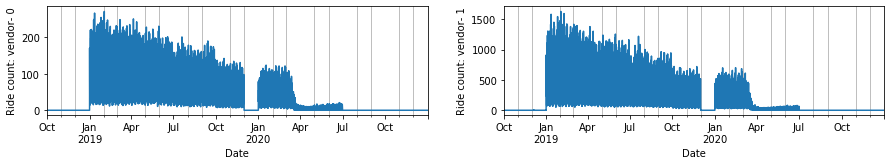

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2), sharex=True)
axx = axs.ravel()
for i in range(0, 2):
    timeseries[i].loc["2018-10-01":"2020-12-31"].plot(ax=axx[i])
    axx[i].set_xlabel("Date")    
    axx[i].set_ylabel("Ride count: vendor- %d" %i)   
    axx[i].grid(which='minor', axis='x')

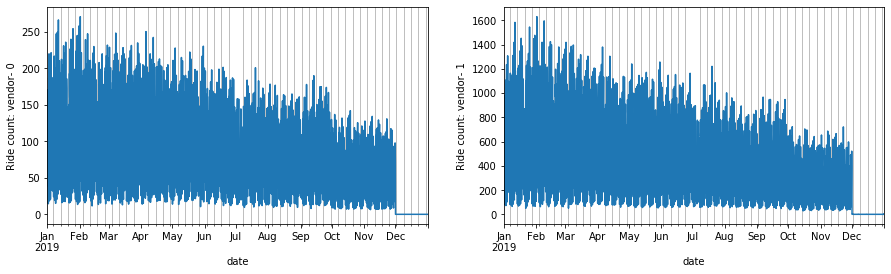

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
axx = axs.ravel()
for i in range(0, 2):
    timeseries[i].loc["2019-01-01":"2019-12-31"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Ride count: vendor- %d" %i)   
    axx[i].grid(which='minor', axis='x')

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [28]:
# we use 2 hour frequency for the time series
freq = '2H'

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

We specify here the portion of the data that is used for training: the model sees data from 2019-01-01 to 2019-04-01 for training.

In [29]:
start_dataset = pd.Timestamp("2019-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2020-01-31 00:00:00", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [30]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training][:-1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]

As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2, 3, 4 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [31]:
num_test_windows = 4

idx =  []
print(len(pd.date_range(start_dataset, end_training )))
period_range = len(pd.date_range(start_dataset, end_training))
      
for i in range(1, num_test_windows + 1) :
    idx.append(pd.date_range(start_dataset, periods = period_range + i * prediction_length, freq=freq))

test_data = [
    {   
        "start": str(start_dataset),
        "target": ts[idx[k]].tolist()
    }
    for k in range(0, num_test_windows)
    for ts in timeseries
]

396


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [32]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [33]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 5.2 ms, sys: 64 µs, total: 5.27 ms
Wall time: 5.49 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes

In [34]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [35]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

File s3://sagemaker-us-east-2-413094830157/s3://sagemaker-us-east-2-413094830157/redshift-deepar-nyctaxi-demo-notebook/data/train/train.json already exists.
Set override to upload anyway.

File s3://sagemaker-us-east-2-413094830157/s3://sagemaker-us-east-2-413094830157/redshift-deepar-nyctaxi-demo-notebook/data/test/test.json already exists.
Set override to upload anyway.

CPU times: user 25.6 ms, sys: 3.81 ms, total: 29.4 ms
Wall time: 97.8 ms


Let's have a look to what we just wrote to S3.

In [36]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2019-01-01 00:00:00", "target": [85.25, 84.25, 43.75, 28.5, 19.75, 26.75, 36.0, 53.0, 63....


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [37]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=redshift_iam_role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='redshift-deepar-nyctaxi-demo',
    output_path=s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use Sagemaker Automated Model Tuning to tune them).

In [38]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [39]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last prediction_length points of each time-series in the test set and comparing this to the actual value of the time-series.

Note: the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [40]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-28 19:09:40 Starting - Starting the training job...
2020-10-28 19:09:41 Starting - Launching requested ML instances......
2020-10-28 19:10:49 Starting - Preparing the instances for training......
2020-10-28 19:11:58 Downloading - Downloading input data...
2020-10-28 19:12:28 Training - Training image download completed. Training in progress.Arguments: train
[10/28/2020 19:12:31 INFO 140083231180608] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log). You can find the definition of these metrics from our documentation. You can use these to optimize the parameters and tune your model or use SageMaker's Automated Model Tuning service to tune the model for you.

   ### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

Create endpoint and predictor
Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [41]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + pd.Timedelta(freq)
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        #prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)
        prediction_index = pd.date_range(prediction_time, periods = prediction_length, freq=freq)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [42]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [43]:
predictor.predict(ts=timeseries[1], quantiles=[0.10, 0.5, 0.90]).head()

0.1       0.9       0.5
2062-08-15 18:00:00  0.000401  0.007388  0.004106
2062-08-15 20:00:00 -0.001318  0.006002  0.002406
2062-08-15 22:00:00 -0.005097  0.012744  0.003536
2062-08-16 00:00:00  0.000940  0.013792  0.007913
2062-08-16 02:00:00 -0.003758  0.006499  0.002122

Below we define a plotting function that queries the model and displays the forecast.

In [44]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    #target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section = target_ts[forecast_date-pd.Timedelta(hours=plot_history):forecast_date+pd.Timedelta(hours=prediction_length)]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                #index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                index = pd.date_range(target_ts.index[0], periods = len(f), freq=target_ts.index.freq),
                data=f
            )
            #feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')
            feat_ts[forecast_date-pd.Timedelta(hours=plot_history):forecast_date+pd.Timedelta(hours=prediction_length)].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [45]:
style = {'description_width': 'initial'}

In [47]:
@interact_manual(
    vendor_id=IntSlider(min=0, max=1, value=1, style=style), 
    forecast_day=IntSlider(min=0, max=100, value=51, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(vendor_id, forecast_day, confidence, history_weeks_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[vendor_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * 12 * 7,
        confidence=confidence
    )

interactive(children=(IntSlider(value=1, description='vendor_id', max=1, style=SliderStyle(description_width='…

### Delete endpoints

In [ ]:
predictor.delete_endpoint()